# Pixelated light in _lenstronomy_
This notebooks aims to be a first tentative to express light on pixelated grid, and building the mapping between source and image planes, for an implementation in _lenstronomy_.

In [1]:
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf

import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
import lenstronomy.Util.util as lenstro_util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.ImSim.Numerics.grid import RegularGrid

from slitronomy.Lensing.lensing_operator import LensingOperator
from slitronomy.Util.plot_util import nice_colorbar
from slitronomy.Util import util

%matplotlib inline

In [2]:
lin_scale = lambda x: x
log_scale = lambda x: np.log10(x)
sqrt_scale = lambda x: np.sqrt(x)

In [3]:
# data specifics
num_pix = 100  # cutout pixel size
delta_pix = 0.08  # pixel size in arcsec (area per pixel = deltaPix**2) -->  if 1, means you we work in pixel units

subgrid_res_source = 2
source_interpolation = 'bilinear'
matrix_prod = True

In [4]:
# data specification (coordinates, etc.)
#kwargs_data = sim_util.data_configure_simple(num_pix, delta_pix, exp_time, background_rms, inverse=False)
_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ \
    = lenstro_util.make_grid_with_coordtransform(numPix=num_pix, deltapix=delta_pix, subgrid_res=1, 
                                                 inverse=True, left_lower=False)

# specify source and image plane grid in lenstronomy classes
image_grid = RegularGrid(num_pix, num_pix, Mpix2coord, ra_at_xy_0, dec_at_xy_0)
source_grid = RegularGrid(num_pix, num_pix, Mpix2coord, ra_at_xy_0, dec_at_xy_0, 
                          supersampling_factor=subgrid_res_source)

# grid coordinates
ra_grid, dec_grid = image_grid.coordinates_evaluate
ra_grid_src, dec_grid_src = source_grid.coordinates_evaluate

kwargs_data = {
    #'background_rms': background_rms,
    #'exposure_time': np.ones((num_pix, num_pix)) * exp_time,  # individual exposure time/weight per pixel
    'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0, 
    'transform_pix2angle': Mpix2coord,
    'image_data': np.zeros((num_pix, num_pix))
}
data_class = ImageData(**kwargs_data)

# PSF specification
kwargs_psf = {'psf_type': 'NONE'}
psf_class = PSF(**kwargs_psf)

lens_model_list = ['SPEP']
kwargs_spemd = {'theta_E': 2, 'gamma': 2, 'center_x': 0.1, 'center_y': 0.05, 'e1': -0.05, 'e2': 0.05}
kwargs_lens = [kwargs_spemd]#, kwargs_shear]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# list of source light profiles
source_model_list = ['SERSIC_ELLIPSE']
kwargs_sersic_ellipse_source = {'amp': 100, 'R_sersic': 0.6, 'n_sersic': 1, 'e1': 0.1, 'e2': 0.1,
                                'center_x': 0.3, 'center_y': 0.3}
kwargs_source = [kwargs_sersic_ellipse_source]
source_model_class = LightModel(light_model_list=source_model_list)

# list of lens light profiles
lens_light_model_list = []
kwargs_lens_light = [{}]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

In [5]:
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

In [6]:
# get the simalated lens image (i.e. image plane)
imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class, 
                        lens_light_model_class, point_source_class=None, kwargs_numerics=kwargs_numerics)

image_sim_no_noise = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps=None)

#poisson = image_util.add_poisson(image_sim_no_noise, exp_time=exp_time)
#bkg = image_util.add_background(image_sim_no_noise, sigma_bkd=background_rms)
#noise = bkg + poisson
image_sim = image_sim_no_noise  # + noise
image_sim_1d = lenstro_util.image2array(image_sim)

kwargs_data['image_data'] = image_sim
data_class.update_data(image_sim)

In [7]:
# get the light distribution in source plane
source_sim_1d = source_model_class.surface_brightness(ra_grid_src, dec_grid_src, kwargs_source)
source_sim = lenstro_util.array2image(source_sim_1d)

In [8]:
# get an automatic mask for that includes the lensed source light
threshold = 0.3
image_mask_1d = np.zeros_like(image_sim_1d)
mask_indices = np.where(image_sim_1d > threshold)
image_mask_1d[mask_indices] = 1
image_mask = lenstro_util.array2image(image_mask_1d)

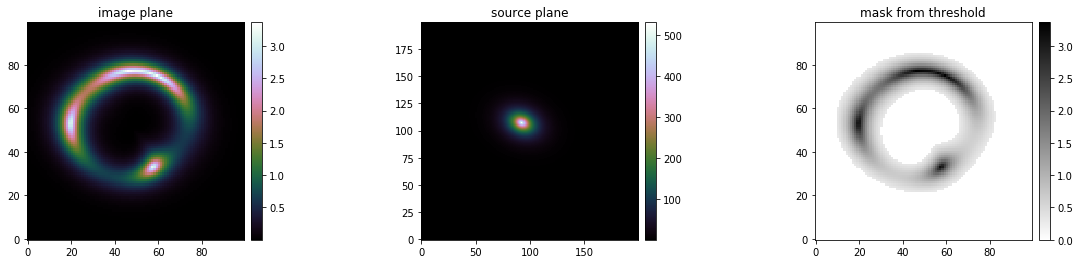

In [9]:
fig = plt.figure(figsize=(20, 4))

ax = plt.subplot2grid((1, 3), (0, 0), fig=fig)
ax.set_title("image plane")
im = ax.imshow(lin_scale(image_sim), origin='lower', cmap='cubehelix')
nice_colorbar(im)

ax = plt.subplot2grid((1, 3), (0, 1))
ax.set_title("source plane")
im = ax.imshow(lin_scale(source_sim), origin='lower', cmap='cubehelix')
nice_colorbar(im)

ax = plt.subplot2grid((1, 3), (0, 2))
ax.set_title("mask from threshold")
im = ax.imshow(image_mask*image_sim, origin='lower', cmap='gray_r')
nice_colorbar(im)

#ax = plt.subplot2grid((1, 4), (0, 2))
#ax.set_title(r"$\alpha_x$")
#im = ax.imshow(alpha_x, origin='lower', cmap='seismic')
#nice_colorbar(im)

#ax = plt.subplot2grid((1, 4), (0, 3))
#ax.set_title(r"$\alpha_y$")
#im = ax.imshow(alpha_y, origin='lower', cmap='seismic')
#nice_colorbar(im)

plt.show()

## Build the mapping between image and source plane

In [10]:
# use kwargs_special to introduce offsets of source plane grid
kwargs_special = {
    'delta_x_source_grid': 0,
    'delta_y_source_grid': 0,
}

In [11]:
lensing_op_class = LensingOperator(lens_model_class, image_grid, source_grid, num_pix, subgrid_res_source, 
                                   source_interpolation=source_interpolation, 
                                   minimal_source_plane=False, min_num_pix_source=10, matrix_prod=matrix_prod)
start_map = time.time()
#%timeit lensing_op_class.update_mapping(kwargs_lens, kwargs_special=kwargs_special)
lensing_op_class.update_mapping(kwargs_lens, kwargs_special=kwargs_special)
print("time to compute mapping : {:.3e} s".format(time.time()-start_map))

time to compute mapping : 9.479e-03 s


In [12]:
# check 4-neighbors mapping for bilinear interpolation
# lensing_op_class.plot_neighbors_map(kwargs_lens, num_image_pixels=675)

## Check mappings

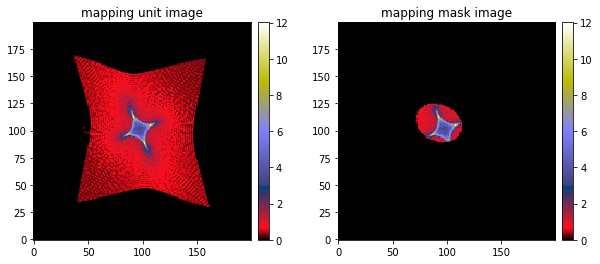

In [13]:
# test images
image_ones_1d = np.ones_like(image_sim_1d)
image_mask_1d  = lenstro_util.image2array(image_mask)
source_ones = lenstro_util.array2image(lensing_op_class.image2source(image_ones_1d, kwargs_lens, 
                                                                     no_flux_norm=True))
source_mask = lenstro_util.array2image(lensing_op_class.image2source(image_mask_1d, kwargs_lens, 
                                                                     no_flux_norm=True))

fig = plt.figure(figsize=(10, 4))

ax = plt.subplot2grid((1, 2), (0, 0), fig=fig)
ax.set_title("mapping unit image")
im = ax.imshow(source_ones, origin='lower', cmap='gist_stern')
nice_colorbar(im)

ax = plt.subplot2grid((1, 2), (0, 1), fig=fig)
ax.set_title("mapping mask image")
im = ax.imshow(source_mask, origin='lower', cmap='gist_stern')
nice_colorbar(im)
plt.show()

## Lensing tests

In [14]:
# from source plane to image plane : "D = F S"
S_vector = source_sim_1d
S = source_sim
start = time.time()
#%timeit D_vector = lensing_op_class.source2image(S_vector)
D_vector = lensing_op_class.source2image(S_vector)
print("runtime, source to image (matrix product) : {:.3e} s".format(time.time()-start))
D = lenstro_util.array2image(D_vector)

# from image plane to source plane : "S = F^{-1} D"
D_vector2 = image_sim_1d
D2 = image_sim
start = time.time()
#%timeit S_vector2 = lensing_op_class.image2source(D_vector2)
S_vector2 = lensing_op_class.image2source(D_vector2)
print("runtime, image to source (matrix product) : {:.3e} s".format(time.time()-start))
S2 = lenstro_util.array2image(S_vector2)

# NOTE : the mathematical inversion of the matrix F is not equivalent of the "delensing" effect

runtime, source to image (matrix product) : 3.610e-04 s
runtime, image to source (matrix product) : 5.231e-04 s


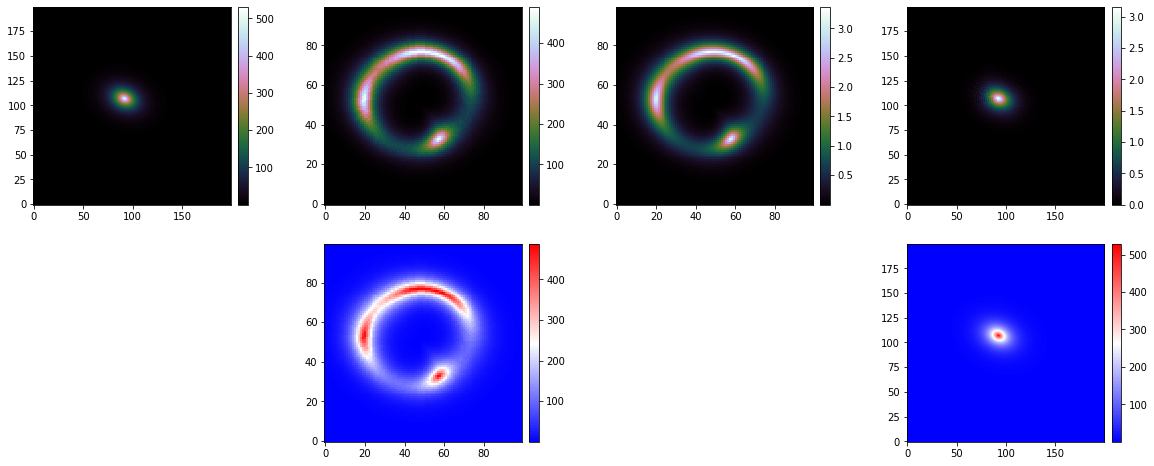

In [15]:
fig = plt.figure(figsize=(20, 8))

ax = plt.subplot2grid((2, 4), (0, 0), fig=fig)
im = ax.imshow(S, origin='lower', cmap='cubehelix')
nice_colorbar(im)

ax = plt.subplot2grid((2, 4), (0, 1), fig=fig)
im = ax.imshow(D, origin='lower', cmap='cubehelix')
nice_colorbar(im)

ax = plt.subplot2grid((2, 4), (0, 2), fig=fig)
im = ax.imshow(D2, origin='lower', cmap='cubehelix')
nice_colorbar(im)

ax = plt.subplot2grid((2, 4), (0, 3), fig=fig)
im = ax.imshow(S2, origin='lower', cmap='cubehelix')
nice_colorbar(im)

ax = plt.subplot2grid((2, 4), (1, 1), fig=fig)
im = ax.imshow(D-D2, origin='lower', cmap='bwr')
nice_colorbar(im)

ax = plt.subplot2grid((2, 4), (1, 3), fig=fig)
im = ax.imshow(S-S2, origin='lower', cmap='bwr')
nice_colorbar(im)

## Check for identity operation

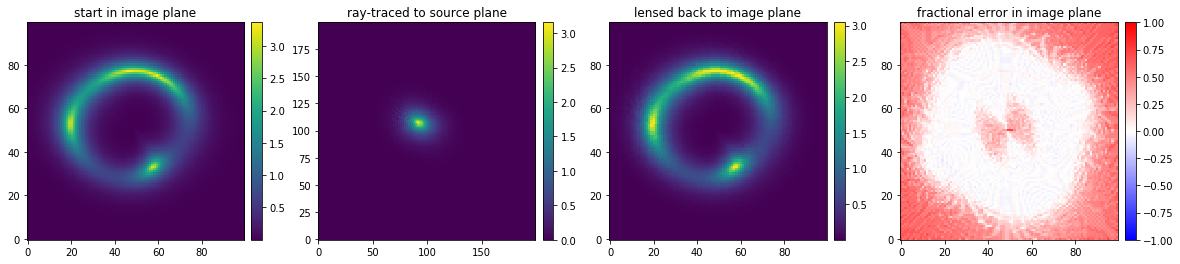

In [16]:
# check that applying F^{-1} then F gives back the same result
# (the inverse can never be true because lensed pixels from source plane are mapped outside image plane)

D = image_sim_1d
S = lensing_op_class.image2source(D)
D_prime = lensing_op_class.source2image(S)

D = lenstro_util.array2image(D)
S = lenstro_util.array2image(S)
D_prime = lenstro_util.array2image(D_prime)


fig = plt.figure(figsize=(20, 4))

ax = plt.subplot2grid((1, 4), (0, 0), fig=fig)
ax.set_title("start in image plane")
im = ax.imshow(D, origin='lower', cmap='viridis')
nice_colorbar(im)

ax = plt.subplot2grid((1, 4), (0, 1), fig=fig)
ax.set_title("ray-traced to source plane")
im = ax.imshow(S, origin='lower', cmap='viridis')
nice_colorbar(im)

ax = plt.subplot2grid((1, 4), (0, 2), fig=fig)
ax.set_title("lensed back to image plane")
im = ax.imshow(D_prime, origin='lower', cmap='viridis')
nice_colorbar(im)

ax = plt.subplot2grid((1, 4), (0, 3), fig=fig)
ax.set_title("fractional error in image plane")
im = ax.imshow((D-D_prime)/D, origin='lower', cmap='bwr', vmin=-1, vmax=1)
nice_colorbar(im)

plt.show()